In [1]:
import ssm
import numpy as np
import matplotlib.pyplot as plt

d:\download_files\Anaconda_app\anaconda_files\envs\env_py_36\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get all 39 sessions
alldat = np.array([])
for j in range(3):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))
                              
alldat.shape

(39,)

In [3]:
dat = alldat[11]   # a dict
print('keys:', len(dat.keys()), dat.keys())

print('')
print('mouse_name:', dat['mouse_name'])
print('date_exp:', dat['date_exp'])
print('brain_area:', dat['brain_area'].shape, np.unique(dat['brain_area']))

print('')
print('bin_size:', dat['bin_size'])
print('stim_onset:', dat['stim_onset'])
print('spks(neurons*trials*time_bins):', dat['spks'].shape, np.unique(dat['spks']))

print('')
print('gocue:', dat['gocue'].shape)
print('contrast_right:', dat['contrast_right'].shape, np.unique(dat['contrast_right']))
print('contrast_left:', dat['contrast_left'].shape, np.unique(dat['contrast_left']))
print('feedback_time:', dat['feedback_time'].shape)
print('feedback_type:', dat['feedback_type'].shape, np.unique(dat['feedback_type']))
print('response_time:', dat['response_time'].shape)
print('response:', dat['response'].shape, np.unique(dat['response']))

print('')
print('active_trials:', dat['active_trials'].shape)
print('reaction_time:', dat['reaction_time'].shape)

print('')
print('pupil:', dat['pupil'].shape)
print('wheel:', dat['wheel'].shape)

keys: 31 dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

mouse_name: Lederberg
date_exp: 2017-12-05
brain_area: (698,) ['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp' 'root']

bin_size: 0.01
stim_onset: 0.5
spks(neurons*trials*time_bins): (698, 340, 250) [0 1 2 3 4 5 6]

gocue: (340, 1)
contrast_right: (340,) [0.   0.25 0.5  1.  ]
contrast_left: (340,) [0.   0.25 0.5  1.  ]
feedback_time: (340, 1)
feedback_type: (340,) [-1.  1.]
response_time: (340, 1)
response: (340,) [-1.  0.  1.]

active_trials: (450,)
reaction_time: (340, 2)

pupil: (3, 340, 250)
wheel: (1

In [63]:
brain_areas = dat['brain_area']
bin_size = dat['bin_size']
stim_onset = dat['stim_onset']
gocue = dat['gocue'] + stim_onset
feedback_time = dat['feedback_time'] + stim_onset
response_time = dat['response_time'] + stim_onset
neural_activity = dat['spks']

# stim_onset = int(stim_onset/bin_size)
# response_time = response_time/bin_size

In [56]:
unique, count=np.unique(brain_areas,return_counts=True)
data_count=dict(zip(unique,count))
data_count
print(unique, count)

['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp' 'root'] [ 16  50  65  11  18 126   6  56 105  79  66 100]


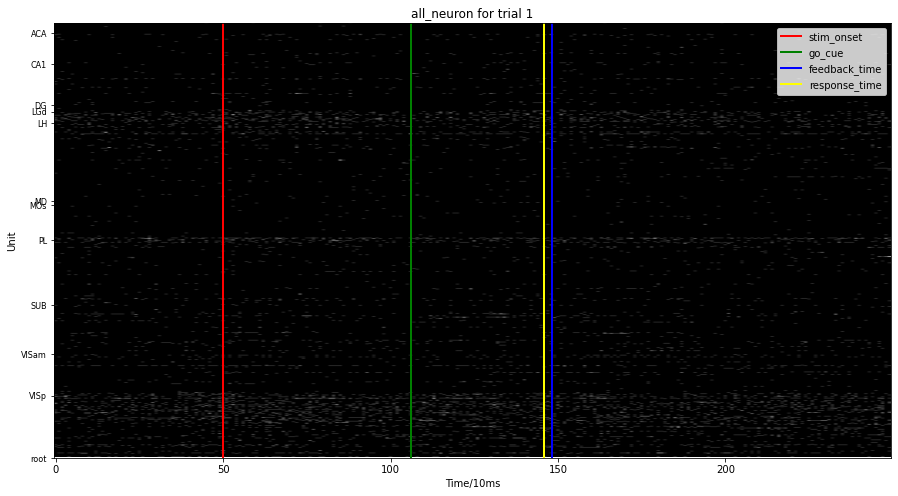

In [66]:
# Display a spike raster of the image

n_trial = 1

plt.figure(figsize=(15,8))
plt.imshow(neural_activity[:,n_trial,:], aspect='auto', cmap='gray')
#plt.axis('off')

# Label the different phases of the trial movement activity
time_bins = neural_activity.shape[2]

plt.axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
plt.axvline(x=gocue[n_trial]/bin_size, color='green', linewidth=2, label='go_cue')
plt.axvline(x=feedback_time[n_trial]/bin_size, color='blue', linewidth=2, label='feedback_time')
plt.axvline(x=response_time[n_trial]/bin_size, color='yellow', linewidth=2, label='response_time')
plt.ylabel("Unit")
plt.xlabel("Time/10ms")

unique, count=np.unique(brain_areas,return_counts=True)
yticklabels = unique
yticklabels_idx = np.cumsum(count)
plt.yticks(yticklabels_idx, yticklabels, fontsize=8)
plt.legend()
plt.tight_layout
plt.title(f'all_neuron for trial {n_trial}')
plt.show()

In [41]:
num_states = 3
num_neurons = neural_activity.shape[0]

# Manually set the initial state distribution
init_dist = ssm.init_state_distns.FixedInitialStateDistribution(num_states,
                                                                num_neurons,
                                                                pi0 = np.array([1, 0, 0]))

# Manually initialize the means for each state
lambdas_before_onset = np.mean(neural_activity[:, n_trial, :stim_onset], axis=(0, 1))
lambdas_onset_response = np.mean(neural_activity[:, n_trial, stim_onset:int(response_time[1])], axis=(0, 1))
lambdas_after_response = np.mean(neural_activity[:, n_trial, int(response_time[1]):], axis=(0, 1))

lambdas = np.vstack((lambdas_before_onset,
                     lambdas_onset_response,
                     lambdas_after_response))

# Manually initialize the transition probabilities
A = np.array(
[[0.8, 0.1, 0],
[0, 0.9, 0.1],
[0, 0, 1]]
)

# Create our HMM
transition_mask = (A > 0)
transition_kwargs = {"transition_mask": transition_mask}
simple_hmm = ssm.HMM(num_states,
                     num_neurons,
                     observations="poisson",
                     transitions="constrained",
                     init_state_distn=init_dist,
                     transition_kwargs=transition_kwargs)

d:\download_files\Anaconda_app\anaconda_files\envs\env_py_36\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


In [43]:
datas = []
for i in range(neural_activity.shape[1]):
    spikes_cur = np.squeeze(neural_activity[:, i, :])

    # Transpose the data for passing to SSM fit function
    # To use the Poisson observation model, we must also
    # convert our arrays to be integer types.
    datas.append(np.asarray(spikes_cur.T, dtype=int))

In [44]:
simple_hmm.log_lambdas = np.log(lambdas)
simple_hmm.transitions.log_Ps = np.log(A)
lls = simple_hmm.fit(datas, method='em')

d:\download_files\Anaconda_app\anaconda_files\envs\env_py_36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
LP: -7959330.1: 100%|██████████| 100/100 [06:36<00:00,  3.96s/it]


In [51]:
# Plot the true and inferred discrete states
hmm_z = simple_hmm.most_likely_states(np.array(datas))

ValueError: operands could not be broadcast together with shapes (340,1,250,698) (3,698) 

In [49]:
hmm_z 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

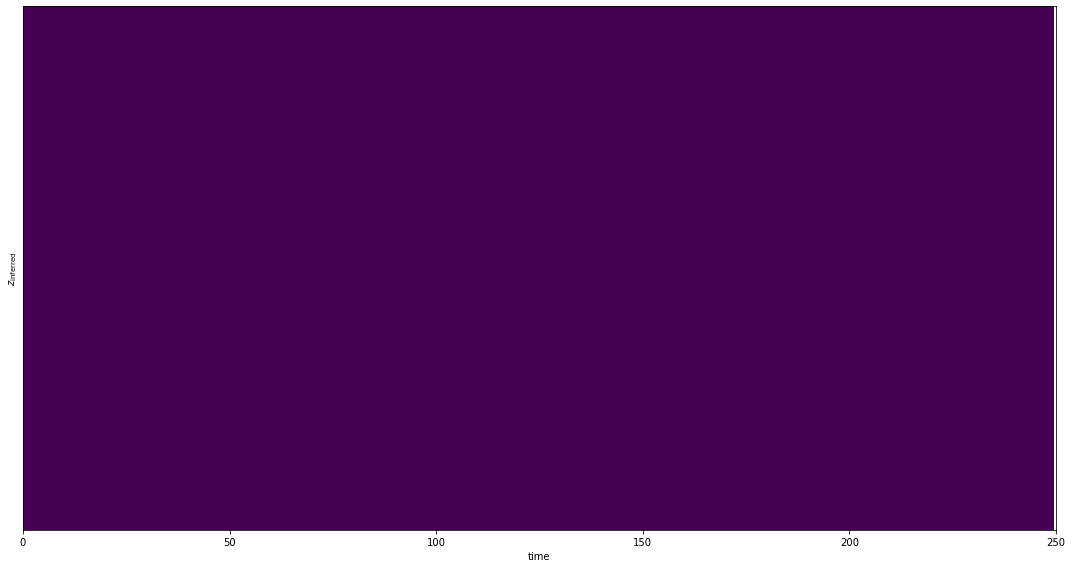

In [48]:
plt.figure(figsize=(15,8))

plt.imshow(hmm_z[None,:], aspect="auto")
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()